In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import requests

from PIL import Image
from io import BytesIO

from tokenizer import tokenize
from model import model_init
from hyperbolic import similarity, specificity


def get_samples():
    image_urls = [
        "https://images.unsplash.com/photo-1526732928503-5c58853877ae",
        "https://images.unsplash.com/photo-1674846194335-d250fdbdc495",
        "https://images.unsplash.com/photo-1522708323590-d24dbb6b0267",
        "https://images.unsplash.com/photo-1664214649073-f4250ad39390",
    ]
    responses = [requests.get(url) for url in image_urls]
    images = [Image.open(BytesIO(response.content)) for response in responses]

    level_0 = ["Blue sky", "Grassy field", "Modern apartment", "Seafood pasta"]
    level_1 = [
        "White clouds against blue sky",
        "Golden grass under stormy sky",
        "Modern minimalist studio with red accents",
        "Creamy seafood pasta with mussels and shrimp",
    ]
    level_2 = [
        "Puffy white cumulus cloud in bright azure summer sky",
        "Wind-swept prairie grassland with dark storm clouds above",
        "Contemporary open-plan studio with red armchair and white kitchen layout",
        "Creamy fettuccine pasta with black mussels, pink shrimp and fresh herbs",
    ]

    return images, level_0, level_1, level_2

In [2]:
images, texts_0, texts_1, texts_2 = get_samples()

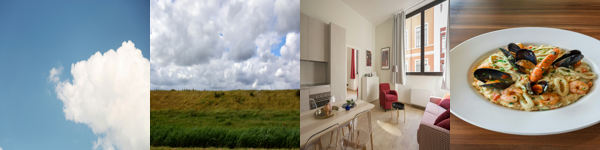

['Blue sky', 'Grassy field', 'Modern apartment', 'Seafood pasta']

['White clouds against blue sky',
 'Golden grass under stormy sky',
 'Modern minimalist studio with red accents',
 'Creamy seafood pasta with mussels and shrimp']

['Puffy white cumulus cloud in bright azure summer sky',
 'Wind-swept prairie grassland with dark storm clouds above',
 'Contemporary open-plan studio with red armchair and white kitchen layout',
 'Creamy fettuccine pasta with black mussels, pink shrimp and fresh herbs']

In [3]:
width, height = 150, 150
resized_images = [im.resize((width, height)) for im in images]
total_width = width * len(resized_images)
combined_image = Image.new("RGB", (total_width, height))

for i, img in enumerate(resized_images):
    combined_image.paste(img, (i * width, 0))

display(combined_image)
display(texts_0)
display(texts_1)
display(texts_2)

In [4]:
model, trs = model_init(pretrained='ckpt.pt')
curv = model.curvature.exp()
images = torch.stack([trs(im) for im in images])
texts_0, texts_1, texts_2 = map(lambda x: tokenize(x), [texts_0, texts_1, texts_2])

model = model.cuda()
model = model.eval()
images, texts_0, texts_1, texts_2 = map(lambda x: x.cuda(), [images, texts_0, texts_1, texts_2])

with torch.no_grad():
    images_feat = model.encode_image(images)
    texts_0_feat = model.encode_text(texts_0)
    texts_1_feat = model.encode_text(texts_1)
    texts_2_feat = model.encode_text(texts_2)

    it0_sim = similarity(images_feat, texts_0_feat, curv)
    it1_sim = similarity(images_feat, texts_1_feat, curv)
    it2_sim = similarity(images_feat, texts_2_feat, curv)
    print(f"{it0_sim.argmax(dim=-1)=}\n{it1_sim.argmax(dim=-1)=}\n{it2_sim.argmax(dim=-1)=}")

    images_spec = specificity(image=images_feat, curv=curv)
    texts_0_spec = specificity(text=texts_0_feat, curv=curv)
    texts_1_spec = specificity(text=texts_1_feat, curv=curv)
    texts_2_spec = specificity(text=texts_2_feat, curv=curv)
    print(f"{images_spec=}\n{texts_0_spec=}\n{texts_1_spec=}\n{texts_2_spec=}")

it0_sim.argmax(dim=-1)=tensor([0, 1, 2, 3], device='cuda:0')
it1_sim.argmax(dim=-1)=tensor([0, 1, 2, 3], device='cuda:0')
it2_sim.argmax(dim=-1)=tensor([0, 1, 2, 3], device='cuda:0')
images_spec=tensor([0.2390, 0.2486, 0.3158, 0.3493], device='cuda:0')
texts_0_spec=tensor([0.1453, 0.2151, 0.1198, 0.2059], device='cuda:0')
texts_1_spec=tensor([0.2238, 0.2891, 0.2781, 0.3468], device='cuda:0')
texts_2_spec=tensor([0.2859, 0.3358, 0.3294, 0.3606], device='cuda:0')
